# ![](https://i.gifer.com/7ARb.gif)

# Abstract

### Introduction

Natural Language Processing (NLP) has been widely used in many areas such as sentiment analysis, topic modeling, and language translation. Emotion classification is one of the most challenging NLP tasks due to the subjective nature of emotions and the difficulty in identifying emotions from textual data. With the increasing popularity of social media platforms, there has been a growing interest in analyzing emotions expressed in tweets. In this Kaggle notebook, I will explore the task of emotion classification using a dataset of tweets.

### Challenge
First, I start with an analysis of the dataset. I quickly realize that the class is quite imbalanced. Several of the 13 emotion classes have less than 200 labeled examples only – this is very low for most machine-learning classification tasks. Most importantly, a simple glance through the dataset signaled that the data is extremely noisy: many of the labels look off. Almost half of the tweets in the dataset are quick replies to some other user's tweet, making them quite meaningless without the original context. A quick search on Twitter shows that these tweets are coming from the year 2009, which is a signal that the data is not representative of today's world. Nevertheless, I go ahead to see how much classification accuracy we can squeeze out of this dataset.

### Approach
I start with custom **Text Pre-processing**: in addition to typical stop-word removal, lemmatization, etc. I also did tweet-specific processing: e.g. removing Twitter handles and URLs, transforming emojis into text (until I found that in 2009 people didn't really use emojis yet). All these give wins on accuracy metrics.

I also do class rebalancing with **Random Over Sampling**. Given it's pretty challenging to get good quality from such noisy data for a 13-class multi-class classification task, **I combine them into 6 classes of emotions** instead. This provides us with another boost in accuracy.

I also try **Data Augmentation**. I loaded an additional, cleaner dataset of tweets with emotion labels and merged it with my training dataset (*leaving the test set original to keep the experiment valid*).

For the classification I use:
* **Logistic Regression** – as a simple baseline, along with finding the best hyperparameters with **GridSearch**;
* **Random Forest**, **Linear SVC**, and stacking them together via **StackingClassifier**;
* **Deep learning: fine-tuning of a pre-trained RoBERTa model** – the heavy weapon of NLP tasks these days, a transfer learning from a BERT-based model, resulting in the highest accuracy for this task.

### Results
**The deep-learned RoBERTa-based classifier produced a weighted accuracy of 44% – as of March 2023 it is the best result on Kaggle for this dataset.**

Unfortunately,the low quality of the ground truth labels did not allow me to get the classification accuracy any higher. As another proof of my approach, I added the last section to this notebook: I used a cleaner dataset with tweets ([Emotions Dataset for NLP](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)) and got the 93% of accuracy with it, significantly surpassing the baseline (69% with Logistic Regression).

Please don't hesitate to reach out, as well as clone my notebook to further improve the results. Here is my LinkedIn: [linkedin.com/in/dmitry-yaroshevsky](http://linkedin.com/in/dmitry-yaroshevsky)


![](https://lh3.googleusercontent.com/pw/AJFCJaWjAJkRrlW7Bgrd_tlX9076vIGHAk7F0rZTZaCoFlsggMlH9yqb6Psr7TFNtEkFGrz6kaQJPWTQFPhhDBAHIiVCcVCV-ThUK5AYUpQMnfIRRVXsISegQfs8UVd9B8hKs49X0oZBPZbC00rrvKtFlxC6=w606-h613-s-no?authuser=0)

### Importing libraries

In [1]:
!pip install contractions
#!pip install nltk
#!pip install transformers

     |████████████████████████████████| 287 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 101 kB 9.3 MB/s eta 0:00:01


In [2]:
import random
import re
import string

import contractions

import nltk
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from transformers import TFRobertaModel, RobertaTokenizerFast
from keras.utils.vis_utils import plot_model
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint


from tabulate import tabulate
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Exploratory Data Analysis

In [5]:
path = '/kaggle/input/emotion-detection-from-text/'

In [6]:
data = pd.read_csv(path + 'tweet_emotions.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
data.drop('tweet_id', axis=1, inplace=True)

sentiment = data.pop('sentiment')
data['sentiment'] = sentiment

data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


,content,sentiment
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


#### A number of tweets for each emotion class:

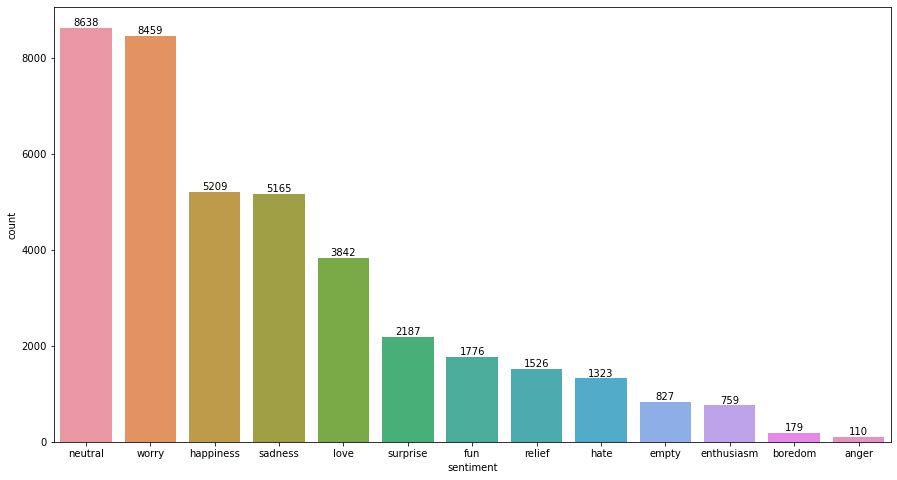

In [8]:
sentiment = data['sentiment'].value_counts()
sentiment_order = list(sentiment.index)

plt.figure(figsize=(15,8))

ax = sns.countplot(x='sentiment', data=data, order=sentiment_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10)
    
plt.show;

#### Mean tweet length for each class

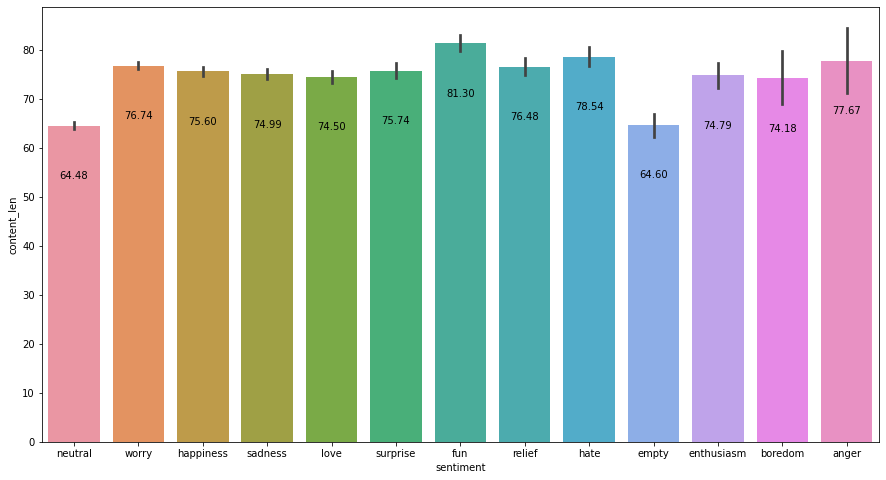

In [9]:
df = data.copy()
df['content_len'] = df['content'].apply(len)

# table
sentiment_grouped_mean_len = df.groupby('sentiment')['content_len'].mean()
sgmlen_transpose = sentiment_grouped_mean_len.to_frame().transpose()

'''
 print(tabulate(sgmlen_transpose.reindex(columns=sentiment_order),
               headers='keys',
               numalign='center',
               stralign='center',
               tablefmt='simple',
               showindex=False))
'''

# barplot
plt.figure(figsize=(15,8))

ax = sns.barplot(data=df, x='sentiment', y='content_len', estimator=np.mean, order=sentiment_order)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -50), 
                textcoords = 'offset points')
    
plt.show;

#### Mean number of words per category

It looks like tweets with neutral and empty emotions are typically shorter:

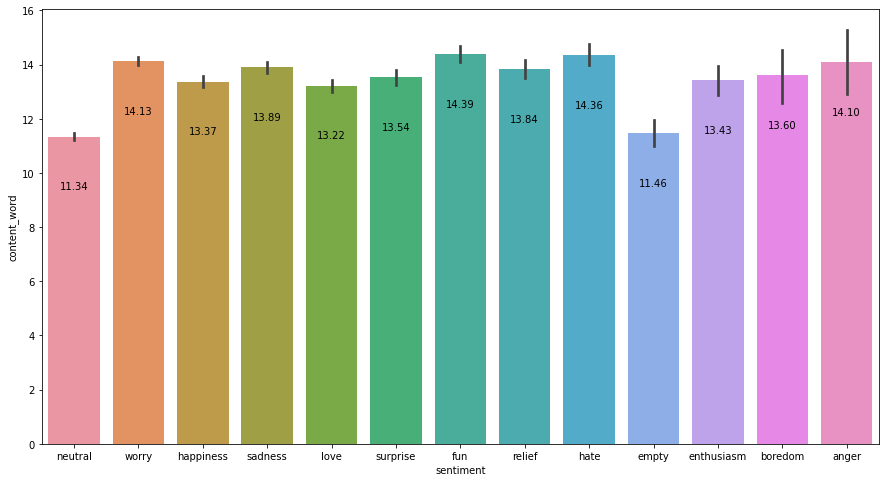

In [10]:
df['content_word'] = data['content'].apply(lambda x: len(x.split()))

# table
sentiment_grouped_mean_word = df.groupby('sentiment')['content_word'].mean()
sgmword_transpose = sentiment_grouped_mean_word.to_frame().transpose()

'''
 print(tabulate(sgmword_transpose.reindex(columns=sentiment_order),
               headers='keys',
               numalign='center',
               stralign='center',
               tablefmt='simple',
               showindex=False))
'''

# barplot
plt.figure(figsize=(15,8))

ax = sns.barplot(data=df, x='sentiment', y='content_word', estimator=np.mean, order=sentiment_order)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -50), 
                textcoords = 'offset points')
    
plt.show;

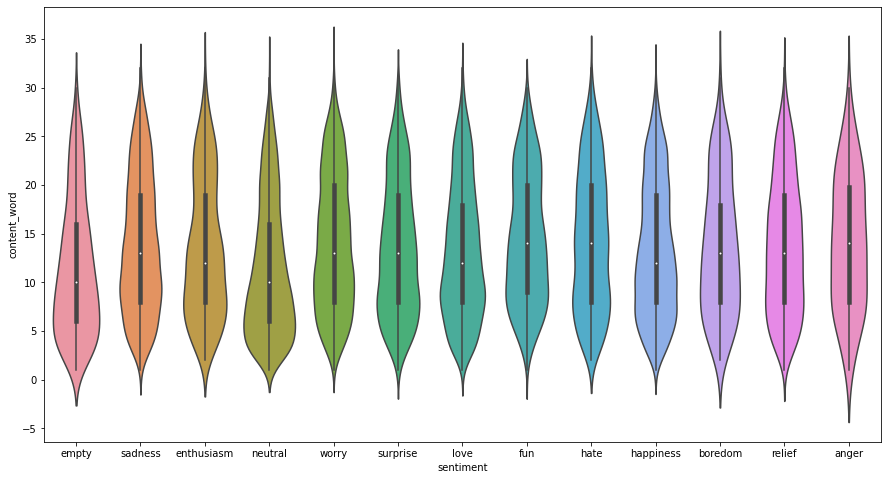

In [11]:
# violinplot
plt.figure(figsize=(15,8))
sns.violinplot(x='sentiment', y = 'content_word', data=df)
plt.show;

#### Distribution of tweet length by emotion class

Notice a second spike on the left plot at ~140 characters in length. A while back the tweets were limited to 140 chars, and thus we see that people were trying to fit their tweets within that limit.

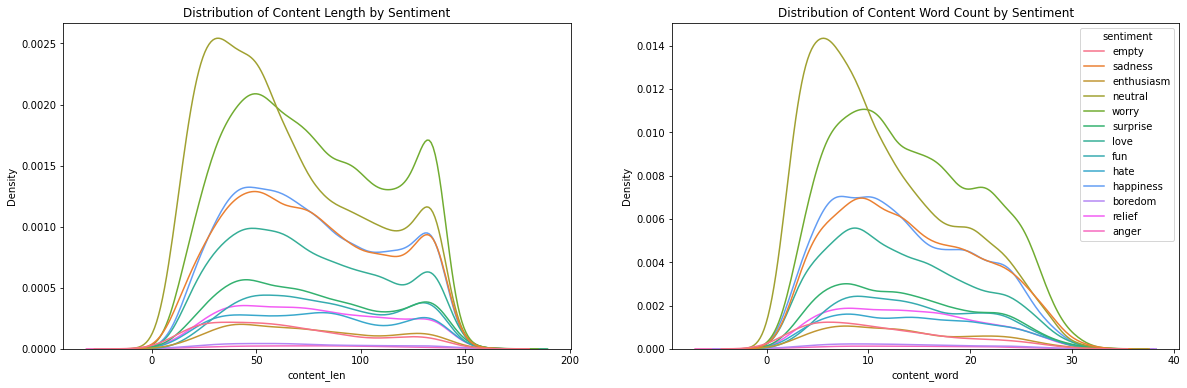

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.kdeplot(x=df['content_len'], hue=df['sentiment'], ax=ax[0], label='content len', legend=False)
ax[0].set_title('Distribution of Content Length by Sentiment')
sns.kdeplot(x=df['content_word'], hue=df['sentiment'], ax=ax[1], label='content word')
ax[1].set_title('Distribution of Content Word Count by Sentiment')

plt.show()

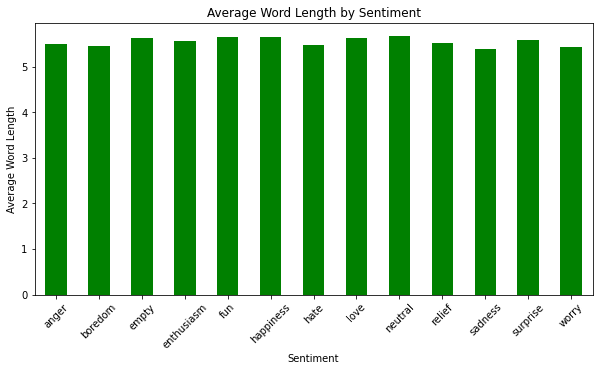

In [13]:
# mean word length for each category.
grouped = df.groupby('sentiment')['content_len', 'content_word'].sum()
grouped['avg_word_len'] = grouped['content_len'] / grouped['content_word']

plt.figure(figsize=(10,5))
ax = grouped['avg_word_len'].plot(kind='bar', color='green')
ax.set_xticklabels(grouped.index, rotation=45)

plt.title('Average Word Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Length')

plt.show()

#### Tweet replies

Almost half of the tweets are replies to other tweets. I tried to retrieve from Twitter what these replies were to and collect those tweets to supplement the dataset with more context. Unfortunately, given the tweets are from the year 2009 most of the data is not available already.

In [14]:
# The number of tweets starting with '@'
count = sum(data['content'].str.startswith('@'))
print(f'The number of replies: {count}')

The number of replies: 18101


# Data Pre-processing

### Cleaning and Lemmatization

In [16]:
df_clean = data.copy()

In [17]:
stop_words = set(stopwords.words('english'))

def expand_contractions(text):
    '''
    Function replaces abbreviations with full word versions
    '''
    return contractions.fix(text)

def clean_content(text):

    text = expand_contractions(text)
    # remove twitter handles
    clean_text = re.sub(r'@\w+\s?', '', text)
    
    # convert to lowercase
    clean_text = clean_text.lower()
    
    # remove links http:// or https://
    clean_text = re.sub(r'https?:\/\/\S+', '', clean_text)
    
    # remove links beginning with www. and ending with .com
    clean_text = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', clean_text)
    
    # remove html reference characters
    clean_text = re.sub(r'&[a-z]+;', '', clean_text)
    
    # remove non-letter characters besides spaces "/", ";" "[", "]" "=", "#"
    clean_text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', clean_text)           
    clean_text = clean_text.split()
    
    # remove stop words
    clean_lst = []
    for word in clean_text:
      if word not in stop_words:
        clean_lst.append(word)
    

    lemmatized_words = []
    for word in clean_lst:
      '''
      # Assign a tag to each part of speech
      tag = pos_tag([word])[0][1][0].upper()
      tag_dict = {'J': wordnet.ADJ,
                  'N': wordnet.NOUN,
                  'V': wordnet.VERB,
                  'R': wordnet.ADV}
      pos = tag_dict.get(tag, wordnet.NOUN)
      
      # lemmatization
      lemmatized_word = WordNetLemmatizer().lemmatize(word, pos)
      '''
      lemmatized_word = WordNetLemmatizer().lemmatize(word)
      lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

df_clean['content'] = df_clean['content'].apply(lambda x :  clean_content(x))

# delete duplicates
df_clean.drop_duplicates(subset='content', inplace=True)
df_clean.reset_index(drop=True, inplace=True)

# delete small sentence
df_clean = df_clean.loc[df_clean['content'].apply(lambda x: len(x) >= 3)]

# splitting into tokens, features of the structure of the text used in Twitter
df_clean['content'] = df_clean['content'].apply(TweetTokenizer().tokenize)

# remove punctuation marks
PUNCUATION_LIST = list(string.punctuation)
def remove_punctuation(word_list):
    return [w for w in word_list if w not in PUNCUATION_LIST]
df_clean['content'] = df_clean['content'].apply(remove_punctuation)
df_clean['content'] = df_clean['content'].apply(lambda x: ' '.join(x))


df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38303 entries, 0 to 38326
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    38303 non-null  object
 1   sentiment  38303 non-null  object
dtypes: object(2)
memory usage: 897.7+ KB


,content,sentiment
0,know listenin bad habit earlier started freaki...,empty
1,layin n bed headache ughhhhwaitin call,sadness
2,funeral ceremonygloomy friday,sadness
3,want hang friend soon,enthusiasm
4,want trade someone houston ticket one,neutral


### WordCloud

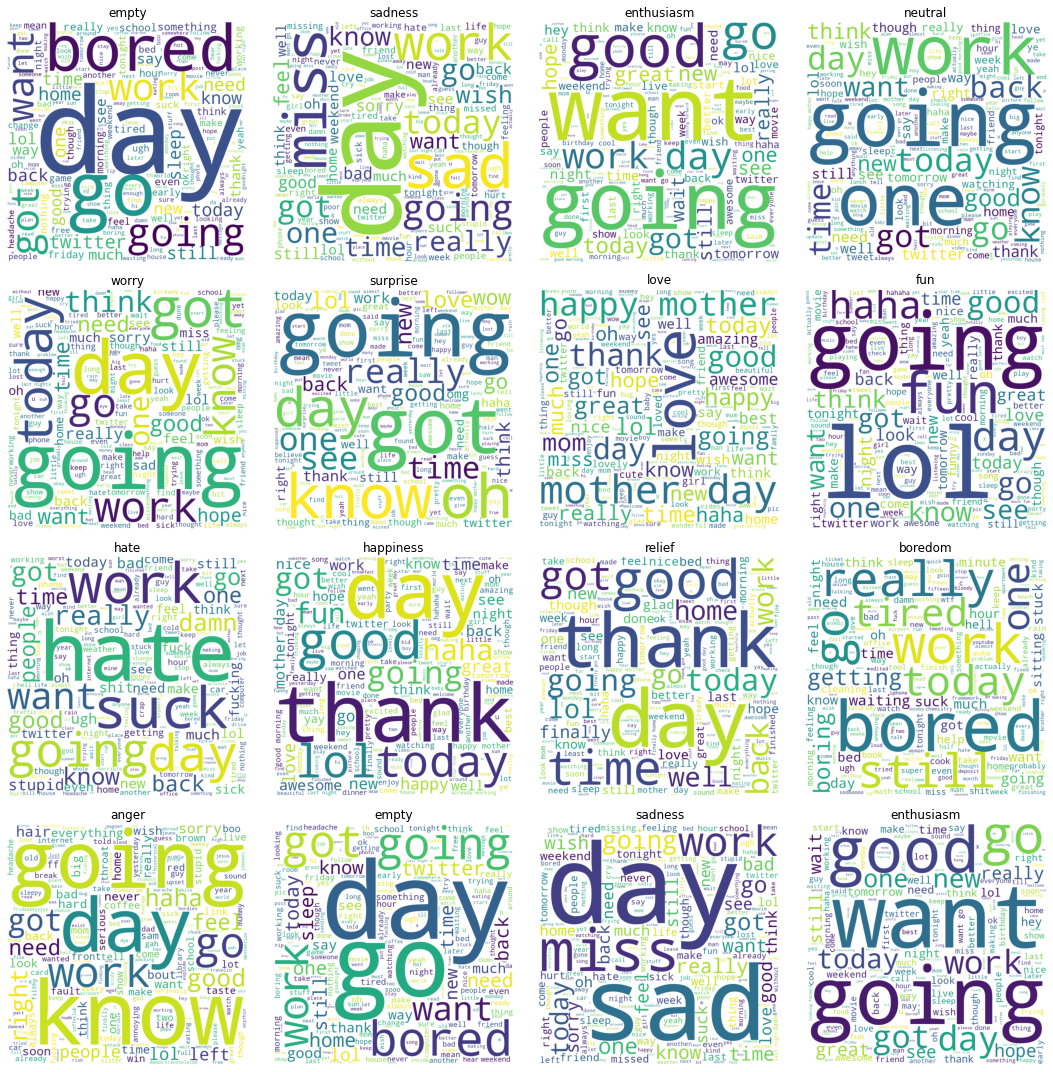

In [18]:
sentiments = df_clean['sentiment'].unique()
sentiments = list(sentiments)
sentiments = list(sentiments) + list(sentiments[:3])

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for ax, sentiment in zip(axes.flatten(), sentiments):
    text = " ".join(df_clean[df_clean['sentiment'] == sentiment]['content'])
    cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    ax.imshow(cloud)
    ax.set_title(sentiment)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Classification Modeling

### Logistic Regression as a baseline

In [19]:
df_train = df_clean.copy()

In [20]:
# Define Confusion Matrix for later use

def conf_matrix(y, y_pred, labels, title):
    fig, ax =plt.subplots(figsize=(10,10))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":15})
    ax.xaxis.set_ticklabels(labels, fontsize=10) 
    ax.yaxis.set_ticklabels(labels, fontsize=10)
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.show()

In [21]:
# Splitting the dataset into training and testing sets

def split_data(df):
  train = df.copy()

  x = np.array(train['content'].values)
  y = np.array(train['sentiment'].values)

  # convert categorical to numeric
  encoder = LabelEncoder()
  y = encoder.fit_transform(y)
  labels = np.unique(encoder.inverse_transform(y))

  # split data on train and test
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

  # convert text to vectors with TF-IDF
  tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
  x_train = tf.fit_transform(x_train).toarray()
  x_test = tf.transform(x_test).toarray()

  return x_train, x_test, y_train, y_test, labels

#### Finding the best hyperparameters with GridSearch

In [ ]:
# Tuning the best hyperparameters
# Uncomment this and this notebook will take much longer to run
'''
def LogR_train_grid(X, x, Y, y, l):

  params = {'penalty': ['l1', 'l2'],
            'C': [0.001, 0.1, 1],}

  lr = LogisticRegression()

  grid = GridSearchCV(lr, param_grid=params, cv=4)      

  grid.fit(X, Y)

  y_pred = grid.predict(x)
  accuracy = grid.score(x, y)

  return accuracy, grid.best_params_

X_train, X_test, y_train, y_test, labels = split_data(df_train)

accuracy, best_param = LogR_train_grid(X_train, X_test, y_train, y_test, labels)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Best parametrs: ', best_param)
'''

#### Training the model with the best parameters found

Accuracy on train: 39.13%
Accuracy on test: 34.71%

Classification Report:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        35
       empty       0.00      0.00      0.00       151
  enthusiasm       0.00      0.00      0.00       146
         fun       0.22      0.03      0.05       350
   happiness       0.35      0.39      0.37      1002
        hate       0.45      0.14      0.21       259
        love       0.46      0.36      0.40       722
     neutral       0.33      0.57      0.42      1605
      relief       0.45      0.06      0.10       295
     sadness       0.35      0.25      0.29      1007
    surprise       0.28      0.04      0.08       424
       worry       0.34      0.46      0.39      1643

    accuracy                           0.35      7661
   macro avg       0.25      0.18      0.18      7661
weighted avg       0.33      0.35      0.31      7661



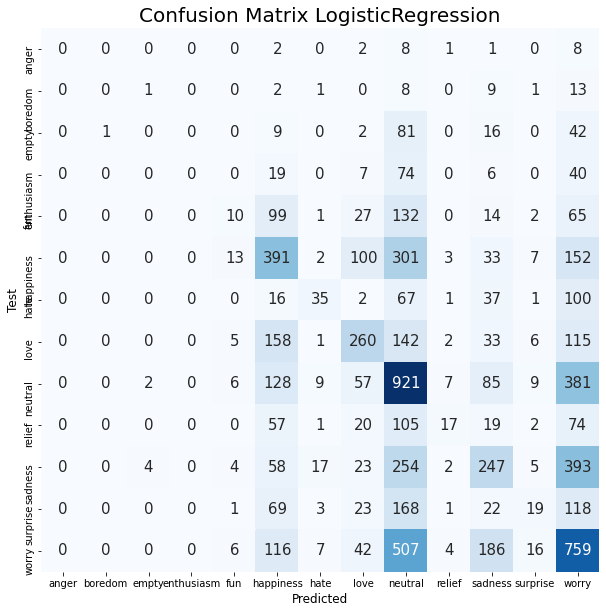

In [22]:
def LogR_train(X, x, Y, y, l):
  
  lr = LogisticRegression()
   
  lr = LogisticRegression(penalty='l2', C=1)
  lr.fit(X, Y)

  y_pred = lr.predict(x)

  accuracy_test = lr.score(x, y)
  accuracy_train = lr.score(X, Y)

  return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels = split_data(df_train)

accuracy_test, accuracy_train, y, y_pred = LogR_train(X_train, X_test, y_train, y_test, labels)


print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix LogisticRegression')

**Overall accuracy: 35%** – this is our baseline.
With our pre-processing and parameters, it's already better than the starter notebook for this dataset.

### Stacking Random Forest and SVC together

Accuracy on train: 38.06%
Accuracy on test: 34.89%

Classification Report:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        35
       empty       0.00      0.00      0.00       151
  enthusiasm       0.00      0.00      0.00       146
         fun       0.00      0.00      0.00       350
   happiness       0.34      0.40      0.37      1002
        hate       0.52      0.12      0.20       259
        love       0.47      0.35      0.40       722
     neutral       0.32      0.61      0.42      1605
      relief       0.63      0.04      0.08       295
     sadness       0.43      0.16      0.23      1007
    surprise       0.33      0.01      0.01       424
       worry       0.34      0.51      0.41      1643

    accuracy                           0.35      7661
   macro avg       0.26      0.17      0.16      7661
weighted avg       0.35      0.35      0.30      7661



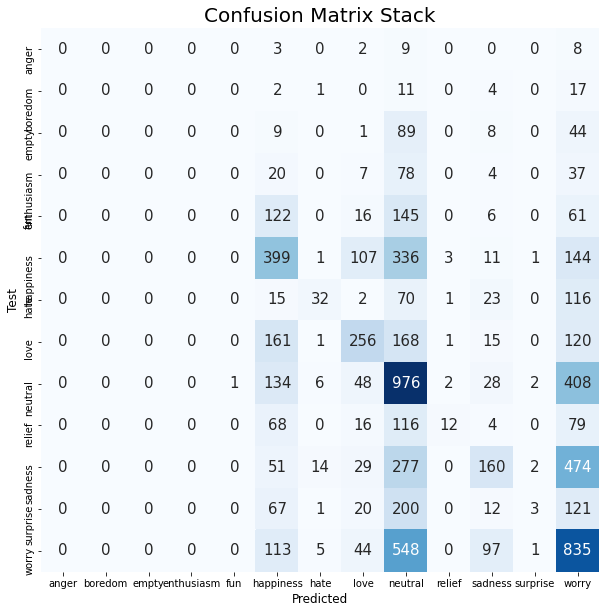

In [24]:

# Create stacking with two estimators: Random Forest and Linear SVC, and a logistic regression as the final estimator

def stacking(X, x, Y, y, l):

    estimators = [
      ('rf', RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=10, max_depth=4, max_features='log2')),
      ('svr', LinearSVC(dual=False, random_state=42))
      ]
    clf_stck = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(penalty='l2', C=1))
    clf_stck.fit(X, Y)

    y_pred = clf_stck.predict(x)

    accuracy_test = clf_stck.score(x, y)
    accuracy_train = clf_stck.score(X, Y)

    return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels = split_data(df_train)

accuracy_test, accuracy_train, y, y_pred = stacking(X_train, X_test, y_train, y_test, labels)

print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix Stack')

**Overall accuracy: 35%** – no gains.

### Reducing emotion classes

This dataset exhibits significant class imbalance, with some categories having very limited data.
As a solution I merge similar categories together:

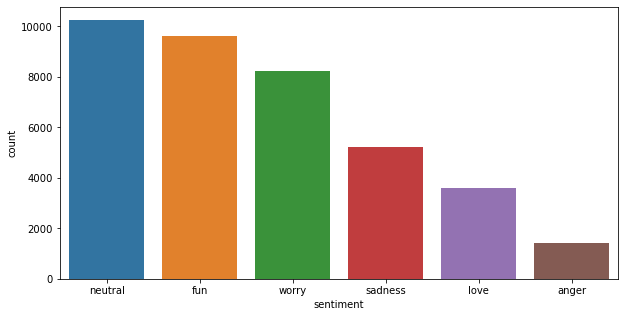

In [25]:
df_reduce = df_train.copy()

df_reduce['sentiment'] = df_reduce['sentiment'].replace(['happiness', 'enthusiasm', 'surprise'], 'fun')
df_reduce['sentiment'] = df_reduce['sentiment'].replace('boredom', 'sadness')
df_reduce['sentiment'] = df_reduce['sentiment'].replace('hate', 'anger')
df_reduce['sentiment'] = df_reduce['sentiment'].replace(['relief', 'empty'], 'neutral')

plt.figure(figsize=(10,5))
ax = sns.countplot(x='sentiment', data=df_reduce, order=df_reduce['sentiment'].value_counts().index)

plt.show();

Accuracy on train: 45.18%
Accuracy on test: 40.60%

Classification Report:

               precision    recall  f1-score   support

       anger       0.56      0.11      0.19       281
         fun       0.43      0.49      0.46      1922
        love       0.53      0.26      0.35       722
     neutral       0.40      0.59      0.47      2051
     sadness       0.42      0.17      0.24      1042
       worry       0.36      0.35      0.35      1643

    accuracy                           0.41      7661
   macro avg       0.45      0.33      0.34      7661
weighted avg       0.42      0.41      0.39      7661



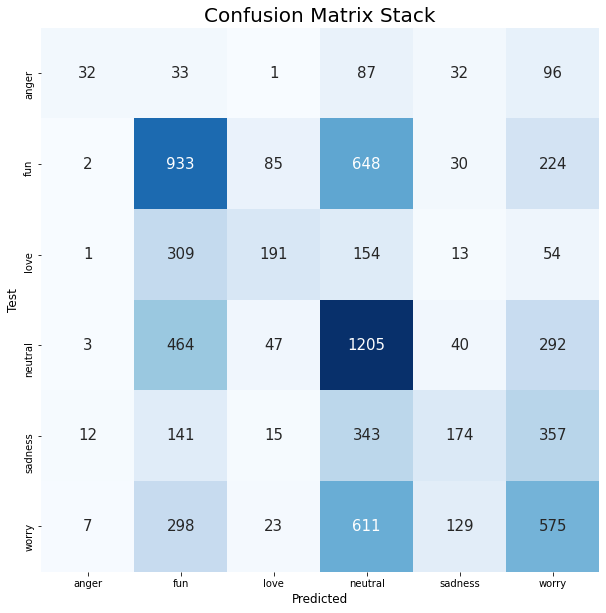

In [26]:
X_train, X_test, y_train, y_test, labels = split_data(df_reduce)

accuracy_test, accuracy_train, y, y_pred = stacking(X_train, X_test, y_train, y_test, labels)

print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix Stack')

**Overall accuracy: 41%** – a good increase so far.

### Balancing the classes

In [28]:
ros = RandomOverSampler()
rus = RandomUnderSampler()

def resize(train_df, test_df, method):

    X = train_df.drop('sentiment', axis=1)
    y = train_df['sentiment'] 

    X_traine_res, y_train_res = method.fit_resample(X, y)

    df_resampled = pd.concat([X_traine_res, y_train_res], axis=1)
    df_total = pd.concat([df_resampled, test_df], axis=0)
    df_total.reset_index(drop=True, inplace=True)


    x_train = np.array(X_traine_res['content'].values)
    x_test = np.array(test_df['content'].values)
    y_train = np.array(y_train_res)
    y_test = np.array(test_df['sentiment'].values)

    # convert categorical to numeric
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.fit_transform(y_test)
    labels = np.unique(encoder.inverse_transform(y_train))

    # convert text to vectors with TF-IDF
    tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
    X_train = tf.fit_transform(x_train).toarray()
    X_test = tf.transform(x_test).toarray()
    
    
    return X_train, X_test, y_train, y_test, df_total, labels

LogisticRegression after over sampling:

Accuracy train: 48.31%
Accuracy on test: 34.88%

Classification Report:

               precision    recall  f1-score   support

       anger       0.12      0.37      0.18       286
         fun       0.47      0.34      0.40      1973
        love       0.33      0.53      0.41       675
     neutral       0.42      0.38      0.40      2063
     sadness       0.27      0.34      0.30      1017
       worry       0.35      0.25      0.29      1647

    accuracy                           0.35      7661
   macro avg       0.33      0.37      0.33      7661
weighted avg       0.38      0.35      0.35      7661



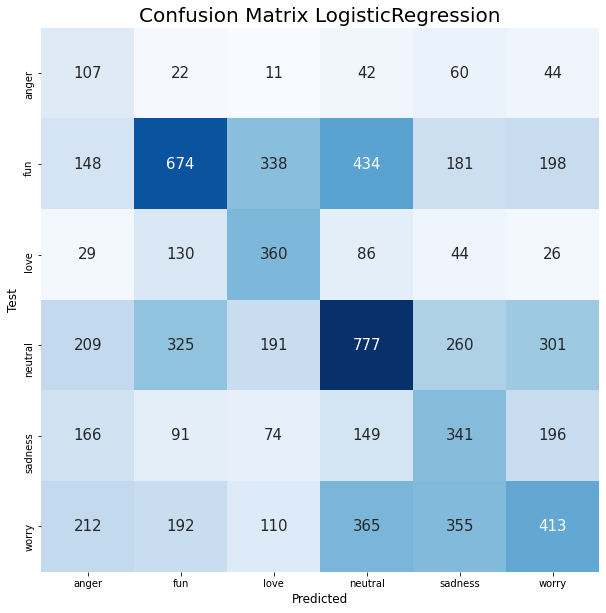

In [29]:
# random over sampling

train_df, test_df = train_test_split(df_reduce, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, df_total, labels = resize(train_df, test_df, ros)

acc_test_LR_reduce, acc_train_LR_reduce, y_LR_reduce, y_pred_LR_reduce = LogR_train(X_train, X_test, y_train, y_test, labels)

print('LogisticRegression after over sampling:\n')
print('Accuracy train: {:.2f}%'.format(acc_train_LR_reduce*100))
print('Accuracy on test: {:.2f}%'.format(acc_test_LR_reduce*100))
print('\nClassification Report:\n\n',classification_report(y_LR_reduce, y_pred_LR_reduce, target_names=[str(l) for l in labels]))
conf_matrix(y_LR_reduce, y_pred_LR_reduce, labels, 'Confusion Matrix LogisticRegression')

**Overall accuracy: 35%** – quality reduced and the diff between test and train increases. The model starts to overfit on noisy data.

### Data Augmentation

Here I try to augment the training set with higher-quality data from another dataset available on Kaggle.

In [32]:
data_emotion = pd.read_csv('/kaggle/input/additional-dataset-for-emotions/data_emotion.csv')
data_emotion.info()
data_emotion['sentiment'] = data_emotion['sentiment'].replace('surprise', 'fun')
data_emotion['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


fun        7480
sadness    5797
anger      2709
worry      2373
love       1641
Name: sentiment, dtype: int64

In [33]:
train_df, test_df = train_test_split(df_reduce, test_size=0.2, random_state=42)
train_df = pd.concat([train_df, data_emotion], axis=0)
train_df.reset_index(drop=True, inplace=True)

In [34]:
def split_df(train_df, test_df):

  x_train = np.array(train_df['content'].values)
  x_test = np.array(test_df['content'].values)
  y_train = np.array(train_df['sentiment'].values)
  y_test = np.array(test_df['sentiment'].values)

  # convert categorical to numeric
  encoder = LabelEncoder()
  y_train = encoder.fit_transform(y_train)
  y_test = encoder.fit_transform(y_test)
  labels = np.unique(encoder.inverse_transform(y_train))

  # convert text to vectors with TF-IDF
  tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
  X_train = tf.fit_transform(x_train).toarray()
  X_test = tf.transform(x_test).toarray()

  return X_train, X_test, y_train, y_test, labels

LogisticRegression after adding new data:

Accuracy train: 48.80%
Accuracy on test: 39.71%

Classification Report:

               precision    recall  f1-score   support

       anger       0.35      0.12      0.17       286
         fun       0.42      0.45      0.44      1973
        love       0.52      0.32      0.40       675
     neutral       0.40      0.56      0.47      2063
     sadness       0.33      0.23      0.27      1017
       worry       0.36      0.30      0.33      1647

    accuracy                           0.40      7661
   macro avg       0.40      0.33      0.35      7661
weighted avg       0.40      0.40      0.39      7661



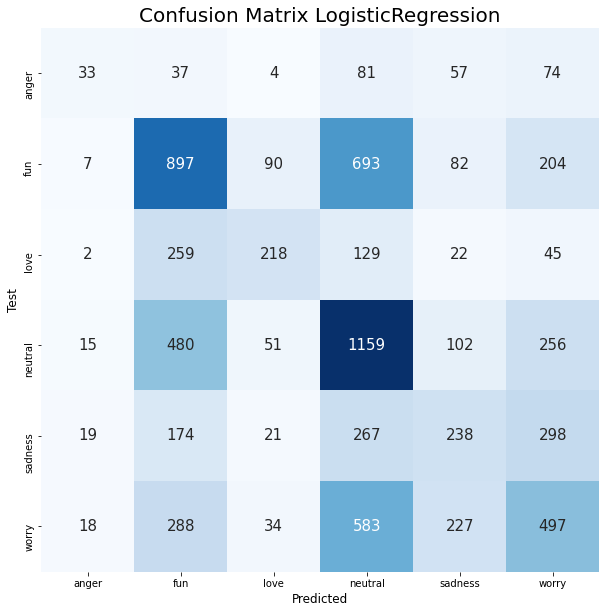

In [35]:
X_train_new, X_test_new, y_train_new, y_test_new, labels_new = split_df(train_df, test_df)

acc_test_LR_reduce, acc_train_LR_reduce, y_LR_reduce, y_pred_LR_reduce = LogR_train(X_train_new, X_test_new, y_train_new, y_test_new, labels_new)

print('LogisticRegression after adding new data:\n')
print('Accuracy train: {:.2f}%'.format(acc_train_LR_reduce*100))
print('Accuracy on test: {:.2f}%'.format(acc_test_LR_reduce*100))
print('\nClassification Report:\n\n',classification_report(y_LR_reduce, y_pred_LR_reduce, target_names=[str(l) for l in labels_new]))
conf_matrix(y_LR_reduce, y_pred_LR_reduce, labels_new, 'Confusion Matrix LogisticRegression')

**Overall accuracy: 40%** – this didn't help much compared to our baseline.

### RoBERTa modeling

Here I go all the way to state-of-the-art approaches in NLP. I use the Transfer Learning technique and load a BERT-based language model to kick-start my model training with pre-trained weights. More specifically, instead of a base BERT model, I use the Twitter-RoBERTa-base-emotion from HuggingFace ([link](https://huggingface.co/cardiffnlp/twitter-roberta-base-emotion)). This model was trained by researchers from Cardiff University (United Kingdom) along with scientists from Snap. It is:

* A Transformer-based model with RoBERTa architecture
* A model trained on ~58M tweets and fine-tuned for emotion recognition with the TweetEval benchmark ([link](https://github.com/cardiffnlp/tweeteval))

I take this model, add a few Dense layers along with a classification layer, and fine-tune it for our dataset.

In [36]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
df_dl = df_reduce.copy()
df_dl.shape

(38303, 2)

In [38]:
train_df, test_df = train_test_split(df_dl, test_size=0.35, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 24896; Test: 13407


In [39]:
# splitting the dataframe into training, validation, and testing data.
X_train = train_df['content'].values
y_train = train_df['sentiment'].values

X = test_df['content'].values
y = test_df['sentiment'].values

X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')


X_train: 24896; X_test: 10055; X_valid: 3352
y_train: 24896; y_test: 10055; y_valid: 3352


In [ ]:
'''
# over sample train_df
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(train_df['content']).reshape(-1, 1), np.array(train_df['sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['content', 'sentiment'])
train_os['sentiment'].value_counts()
'''

In [ ]:
'''
X_train = train_os['content'].values
y_train = train_os['sentiment'].values

X = test_df['content'].values
y = test_df['sentiment'].values

X = test_df['content'].values
y = test_df['sentiment'].values

X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')
'''

In [40]:
# category to binary
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [41]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [42]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

65

In [43]:
#setting MAX_LEN token size for the BERT input
MAX_LEN=128

In [44]:
def tokenize_roberta(data, max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_inputs, train_masks = tokenize_roberta(X_train, MAX_LEN)
val_inputs, val_masks = tokenize_roberta(X_valid, MAX_LEN)
test_inputs, test_masks = tokenize_roberta(X_test, MAX_LEN)

In [45]:
# TPU training – much faster for this task. Move the code out from the tpu_strategy.scope() to do GPU training instead

# detect and init the TPU and then instantiate a distribution strategy
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
#with tpu_strategy.scope():

# Creating a neural network model based on a pre-trained BERT model
# and adding several dense and dropout layers with softmax activation for multi-class classification.

def create_model(bert_model, max_len=MAX_LEN):
    inputs = Input(shape=(max_len,), dtype='int32')
    masks = Input(shape=(max_len,), dtype='int32')

    bert_output = bert_model([inputs, masks])[1]

    dense_1 = Dense(128, activation='relu')(bert_output)
    dropout_1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(64, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.5)(dense_2)

    output = Dense(6, activation='softmax')(dropout_2)

    model = Model(inputs=[inputs, masks], outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-7),
                      loss=CategoricalCrossentropy(),
                      metrics=CategoricalAccuracy())
    return model

roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')
model = create_model(roberta_model, MAX_LEN)
print(model.summary())

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          98432       tf_roberta_model[0][1]       

In [ ]:
#plot_model(model, show_shapes=True)

In [46]:
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', patience=5, min_delta=0.001),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', save_best_only=True)]

In [47]:
history = model.fit(
    [train_inputs, train_masks],
    y_train,
    validation_data=([val_inputs, val_masks], y_valid),
    epochs=4,
    batch_size=32)

Epoch 1/4
778/778 [==============================] - 381s 478ms/step - loss: 1.6903 - categorical_accuracy: 0.2854 - val_loss: 1.4630 - val_categorical_accuracy: 0.4284
Epoch 2/4
778/778 [==============================] - 368s 474ms/step - loss: 1.5603 - categorical_accuracy: 0.3733 - val_loss: 1.4261 - val_categorical_accuracy: 0.4338
Epoch 3/4
778/778 [==============================] - 368s 473ms/step - loss: 1.4927 - categorical_accuracy: 0.4136 - val_loss: 1.4251 - val_categorical_accuracy: 0.4391
Epoch 4/4
778/778 [==============================] - 368s 473ms/step - loss: 1.4581 - categorical_accuracy: 0.4360 - val_loss: 1.4203 - val_categorical_accuracy: 0.4371


In [49]:
result_roberta = model.predict([test_inputs, test_masks])

In [50]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

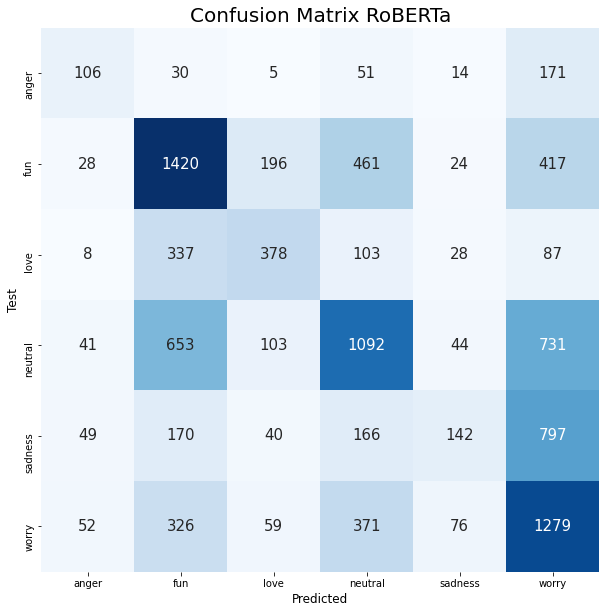

In [51]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1), labels, 'Confusion Matrix RoBERTa')

In [52]:
print('Classification Report:\n\n',classification_report(y_test,y_pred_roberta, target_names=labels))

Classification Report:

               precision    recall  f1-score   support

       anger       0.37      0.28      0.32       377
         fun       0.48      0.56      0.52      2546
        love       0.48      0.40      0.44       941
     neutral       0.49      0.41      0.44      2664
     sadness       0.43      0.10      0.17      1364
       worry       0.37      0.59      0.45      2163

   micro avg       0.44      0.44      0.44     10055
   macro avg       0.44      0.39      0.39     10055
weighted avg       0.45      0.44      0.42     10055
 samples avg       0.44      0.44      0.44     10055



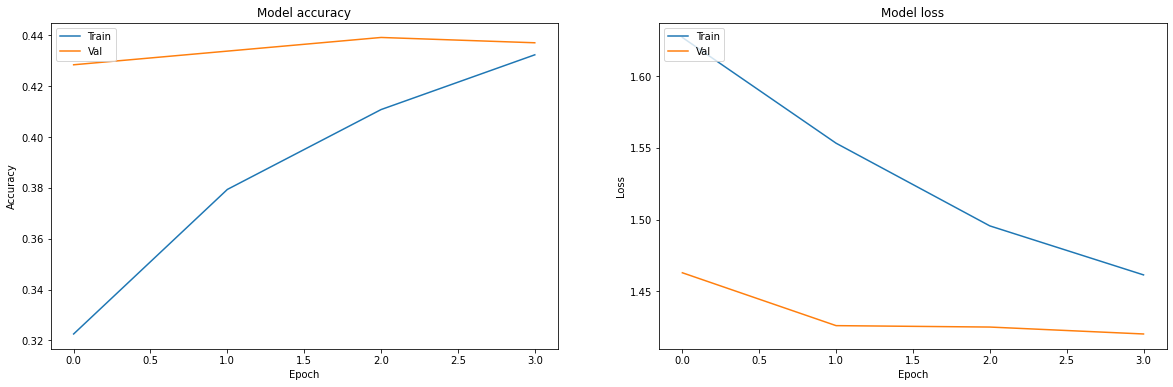

In [55]:
# Plot training and validation accuracy + loss in one figure
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

Random examples with the difference between ground truth and prediction. You can see how noisy the input data is:

In [61]:
def get_wrong_predictions_df(X, y, predict, labels):
    # Create an empty dataframe
    wrong_preds_df = pd.DataFrame(columns=['content', 'sentiment', 'prediction'])
    
    for i, x in enumerate(X):
        # Get the sentiment label and predicted label
        sentiment = np.argmax(y[i])
        prediction = np.argmax(predict[i])
        
        # If the sentiment and predicted label don't match, add the example to the dataframe
        if sentiment != prediction:
            row = {'content': x, 'sentiment': sentiment, 'prediction': prediction}
            wrong_preds_df = wrong_preds_df.append(row, ignore_index=True)

    # Create a mapping between numerical labels and string labels
    label_map = {num_label: str_label for num_label, str_label in enumerate(labels)}

    # Replace numerical labels with string labels
    wrong_preds_df['sentiment'] = wrong_preds_df['sentiment'].map(label_map)
    wrong_preds_df['prediction'] = wrong_preds_df['prediction'].map(label_map)
    
    return wrong_preds_df

wrong_preds_df = get_wrong_predictions_df(X_test, y_test, result_roberta, labels)


wrong_preds_df.sample(n=8)

,content,sentiment,prediction
4024,know told want stay home lied really want stay...,sadness,worry
2277,phone work whack well good morning going go ea...,neutral,worry
965,oh thought man-ly problem able figure mom offi...,fun,worry
3568,funny outgoing email issue day thank god seper...,worry,fun
2879,really worth watching cinema mum really enjoyed,love,fun
1988,timeeee mom say something daw tomorrow eh neve...,sadness,worry
3862,soooooooooo glad learn farrell ice cream parlo...,sadness,fun
3352,sexy time coming town meeting ish,neutral,fun


**Overall accuracy: 44%** – the highest accuracy achieved so far. 

Unfortunately still not great for production use, but this dataset is very noisy. In the next section, I'll show what this approach can do on a cleaner dataset of tweets with emotions.


# P.S. Sanity-checking my approach on a cleaner dataset

In [77]:
path = '/kaggle/input/emotions-dataset-for-nlp/'

train_df = pd.read_csv(path + 'train.txt', sep=';', names=['content', 'sentiment'], header=0)
test_df = pd.read_csv(path + 'test.txt', sep=';', names=['content', 'sentiment'], header=0)
valid_df = pd.read_csv(path + 'val.txt', sep=';', names=['content', 'sentiment'], header=0)
df_train = pd.concat([train_df, test_df, valid_df], axis=0)

In [64]:
# Confusion Matrix
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(10,10))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.show()

Accuracy on train: 75.57%
Accuracy on test: 69.23%

Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.54      0.66       542
           1       0.77      0.57      0.66       475
           2       0.67      0.85      0.75      1352
           3       0.75      0.42      0.54       328
           4       0.66      0.75      0.70      1159
           5       0.72      0.34      0.46       144

    accuracy                           0.69      4000
   macro avg       0.73      0.58      0.63      4000
weighted avg       0.71      0.69      0.68      4000



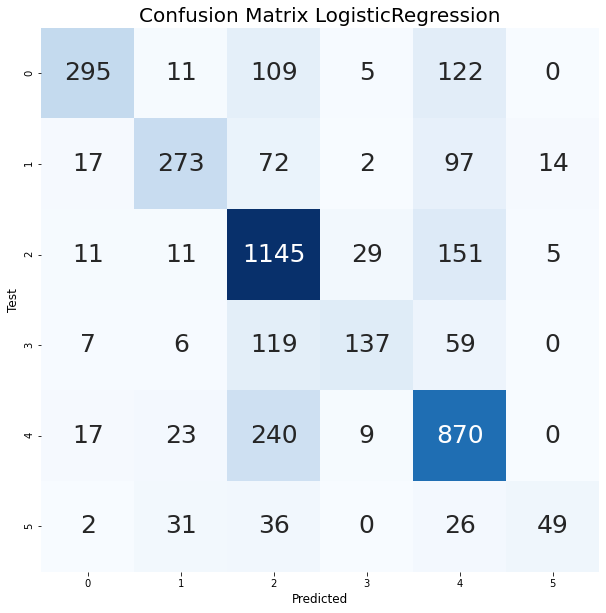

In [65]:
def LogR_train(X, x, Y, y, l):
  
  lr = LogisticRegression()
   
  lr = LogisticRegression(penalty='l2', C=1)
  lr.fit(X, Y)

  y_pred = lr.predict(x)

  accuracy_test = lr.score(x, y)
  accuracy_train = lr.score(X, Y)

  return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels = split_data(df_train)

acc_test_LR, acc_train_LR, y_LR, y_pred_LR = LogR_train(X_train, X_test, y_train, y_test, labels)

print('Accuracy on train: {:.2f}%'.format(acc_train_LR*100))
print('Accuracy on test: {:.2f}%'.format(acc_test_LR*100))
print('\nClassification Report:\n\n',classification_report(y_LR , y_pred_LR))
conf_matrix(y_LR , y_pred_LR, 'Confusion Matrix LogisticRegression')

**Overall accuracy: 69%** – let's take this as a baseline for this new dataset.

In [78]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(np.array(train_df['content']).reshape(-1, 1), np.array(train_df['sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in x_train], y_train)), columns = ['content', 'sentiment'])
train_os['sentiment'].value_counts()

love        5362
fear        5362
surprise    5362
joy         5362
anger       5362
sadness     5362
Name: sentiment, dtype: int64

In [79]:
X_train = train_os['content'].values
y_train = train_os['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

X_valid = valid_df['content'].values
y_valid = valid_df['sentiment'].values

In [80]:
y_train = OneHotEncoder().fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = OneHotEncoder().fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = OneHotEncoder().fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [81]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

88

In [82]:
MAX_LEN=128

In [83]:
def tokenize_roberta(data, max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_inputs, train_masks = tokenize_roberta(X_train, MAX_LEN)
val_inputs, val_masks = tokenize_roberta(X_valid, MAX_LEN)
test_inputs, test_masks = tokenize_roberta(X_test, MAX_LEN)

In [84]:
def create_model(bert_model, max_len=MAX_LEN):
    inputs = Input(shape=(max_len,), dtype='int32')
    masks = Input(shape=(max_len,), dtype='int32')

    bert_output = bert_model([inputs, masks])[1]

    dense_1 = Dense(128, activation='relu')(bert_output)
    dropout_1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(64, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.5)(dense_2)

    output = Dense(6, activation='softmax')(dropout_2)

    model = Model(inputs=[inputs, masks], outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-7),
                  loss=CategoricalCrossentropy(),
                  metrics=CategoricalAccuracy())
    return model

roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')
model = create_model(roberta_model, MAX_LEN)
print(model.summary())

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_2 (TFRobertaMo TFBaseModelOutputWit 124645632   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          98432       tf_roberta_model_2[0][1]   

In [ ]:
#plot_model(model, show_shapes=True)

In [74]:
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', patience=5, min_delta=0.01),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', save_best_only=True)]

In [85]:
history = model.fit(
    [train_inputs, train_masks],
    y_train,
    validation_data=([val_inputs, val_masks], y_valid),
    epochs=4,
    batch_size=32)

Epoch 1/4
1006/1006 [==============================] - 503s 486ms/step - loss: 1.1957 - categorical_accuracy: 0.5479 - val_loss: 0.3187 - val_categorical_accuracy: 0.9105
Epoch 2/4
1006/1006 [==============================] - 486s 483ms/step - loss: 0.3549 - categorical_accuracy: 0.9020 - val_loss: 0.2699 - val_categorical_accuracy: 0.9240
Epoch 3/4
1006/1006 [==============================] - 486s 483ms/step - loss: 0.2614 - categorical_accuracy: 0.9228 - val_loss: 0.2457 - val_categorical_accuracy: 0.9275
Epoch 4/4
1006/1006 [==============================] - 486s 483ms/step - loss: 0.2173 - categorical_accuracy: 0.9350 - val_loss: 0.2149 - val_categorical_accuracy: 0.9310


In [88]:
result_roberta = model.predict([test_inputs, test_masks])

In [89]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

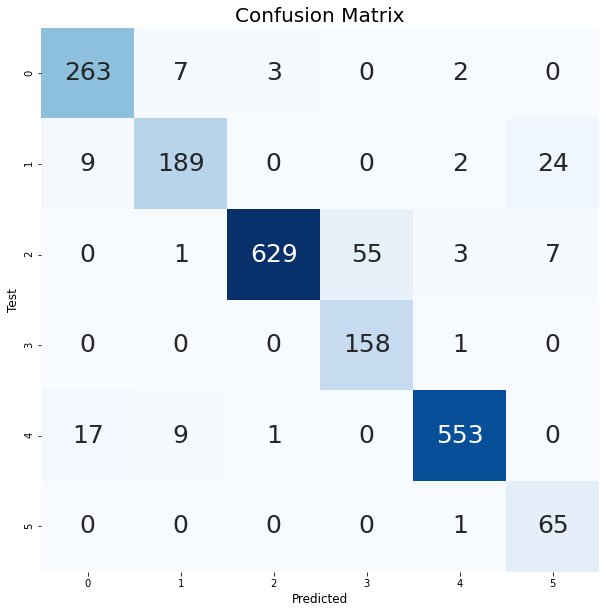

In [90]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(10,10))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.show()

conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'Confusion Matrix')

In [91]:
print('Classification Report:\n\n',classification_report(y_test,y_pred_roberta))

Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.96      0.93       275
           1       0.92      0.84      0.88       224
           2       0.99      0.91      0.95       695
           3       0.74      0.99      0.85       159
           4       0.98      0.95      0.97       580
           5       0.68      0.98      0.80        66

   micro avg       0.93      0.93      0.93      1999
   macro avg       0.87      0.94      0.90      1999
weighted avg       0.94      0.93      0.93      1999
 samples avg       0.93      0.93      0.93      1999



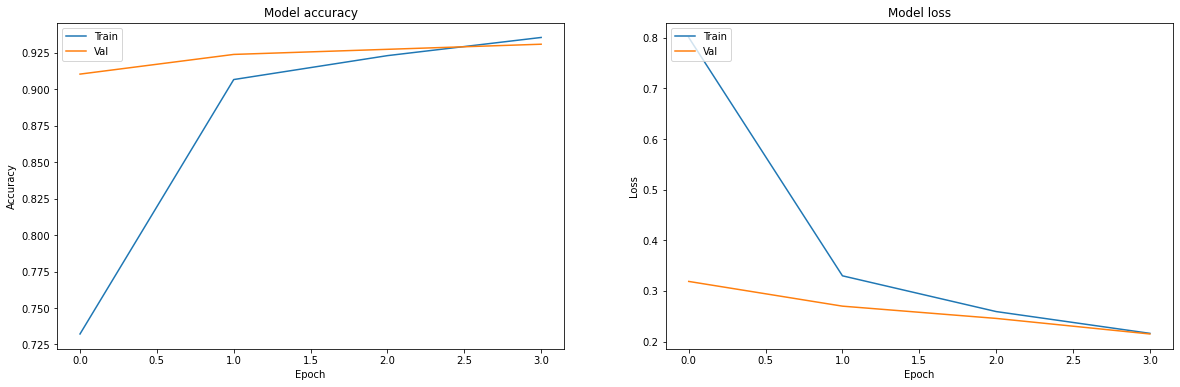

In [92]:
# Plot training and validation accuracy and loss in one figure
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

**Overall accuracy: 93%**